# Реализуем простую модель BI-LSTM и BI-LSTM with attention

# модель BI-LSTM

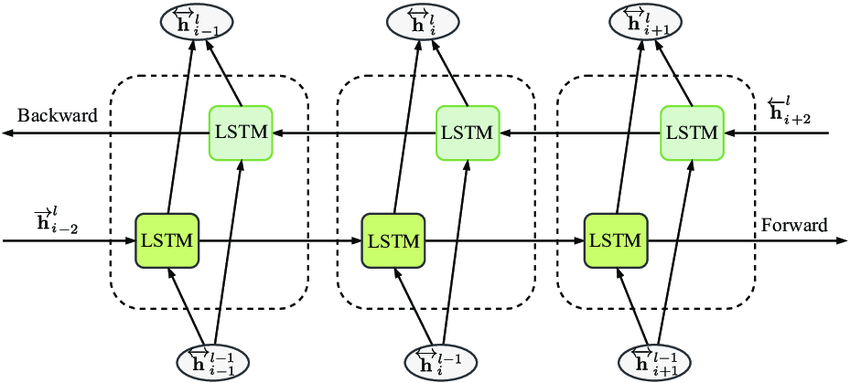

# модель BI-LSTM with attention

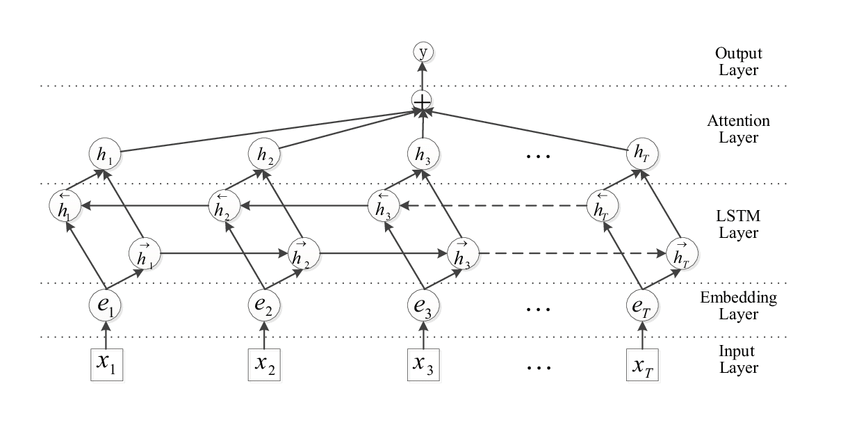

In [26]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

# В моделях используеся keras.dataset, предоставленный набором данных imdb.
# Набор данных содержит классифицированные отзывы зрителей фильма.

Импорт набора данных.

In [27]:
n_unique_words = 10000
(x_train, y_train),(x_test, y_test) = imdb.load_data(num_words=n_unique_words)

17464789/17464789 [==============================] - 1s 0us/step


Последовательность данных.

In [28]:
maxlen = 200
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.utils.pad_sequences(x_test, maxlen=maxlen)
y_train = np.array(y_train)
y_test = np.array(y_test)

Определение модели Bi-LSTM.

In [29]:
model = Sequential()
model.add(Embedding(n_unique_words, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(x_train, y_train,
           batch_size=128,
           epochs=12,
           validation_data=[x_test, y_test])
print(history.history['loss'])
print(history.history['accuracy'])

Epoch 1/12
196/196 [==============================] - 283s 1s/step - loss: 0.4506 - accuracy: 0.7881 - val_loss: 0.3112 - val_accuracy: 0.8676
Epoch 2/12
196/196 [==============================] - 270s 1s/step - loss: 0.2411 - accuracy: 0.9101 - val_loss: 0.3600 - val_accuracy: 0.8630
Epoch 3/12
196/196 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9330

# Определим слой внимания.
### Импорт библиотек.

In [ ]:
from keras.layers import *
from keras.models import *
from keras import backend as K

### Определение класса внимания.

In [ ]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
# Внутри build() функция будет определять смещения с весами.
# Если выходная форма любого слоя LSTM (None, 64, 128), то наш выходной вес и смещение будут иметь форму (128, 1). 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
# Функция call() возьмет произведение весов и добавит условия смещения, чтобы попасть вперед в качестве входных данных. 
# После этого за tanh следует слой softmax, он дает выравнивание оценок.

### Создание модели с использованием слоя attention, где return_sequence = true

In [ ]:
model2 = Sequential()
model2.add(Embedding(n_unique_words, 128, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, return_sequences=True)))
model2.add(attention())   # receive 3D and output 3D
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model2.summary()

In [ ]:
# обучаем модель 
batch_size = 128 
epochs = 12

history3d=model2.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=12,
           validation_data=[x_test, y_test])
print(history3d.history['loss'])
print(history3d.history['accuracy'])